### Import Libraries

In [1]:
# Import libraries.
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from IPython.display import IFrame

%matplotlib inline

### Load Dataset

The dataset we're loading here is the [Global Shark Attack File](http://www.sharkattackfile.net), a compilation of shark attacks across the globe.

In [2]:
# Load in dataset.
df = pd.read_csv('data/GSAF5.csv')

# Get shape.
print(df.shape)

# Check data load.
df.head()

(23402, 24)


,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2019.01.08,8-Jan-2019,2019.0,Unprovoked,USA,California,"Sandspit Beach, Montaña de Oro State Park",Surfing,Nick Wapner,M,...,"White shark, 4.6m","K. McMurray, TrackingSharks.com",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018.12.18,18-Dec-2018,2018.0,Unprovoked,MEXICO,Sonora,Southeast of Puerto Peñasco,Diving,Nahum Verdugo Aguilera,M,...,Tiger shark,"K. McMurray, TrackingSharks.com",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018.12.15.b,15-Dec-2018,2018.0,Provoked,AUSTRALIA,New South Wales,NaN,NaN,male,M,...,Wobbegong shark,"B. Myatt, GSAF",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018.12.15.a,15-Dec-2018,2018.0,Provoked,NEW ZEALAND,North Island,Matauri Bay,Spearfishing,Kevin Lloyd,M,...,"Mako shark, 7'","K. McMurray, TrackingSharks.com",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018.12.09.b,09-Dec-2018,2018.0,Unprovoked,NEW ZEALAND,North Island,Ti Point,Spearfishing,Anton Oleinik,M,...,Bronze whaler 2.5m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.Country.str.lower().unique()

array(['usa', 'mexico', 'australia', 'new zealand', 'south africa',
       'bahamas', 'egypt', 'china', 'colombia', 'brazil', 'england',
       'thailand', 'costa rica', 'maldives', 'new caledonia', 'ecuador',
       'malaysia', 'libya', nan, 'cuba', 'mauritius', 'spain', 'samoa',
       'solomon islands', 'japan',
       'st helena, british overseas territory', 'comoros', 'reunion',
       'french polynesia', 'united kingdom', 'united arab emirates',
       'philippines', 'indonesia', 'columbia', 'cape verde', 'fiji',
       'dominican republic', 'cayman islands', 'aruba', 'mozambique',
       'puerto rico', 'italy', 'atlantic ocean', 'greece', 'st. martin',
       'france', 'papua new guinea', 'trinidad & tobago', 'kiribati',
       'israel', 'diego garcia', 'taiwan', 'jamaica',
       'palestinian territories', 'guam', 'seychelles', 'belize',
       'nigeria', 'tonga', 'scotland', 'canada', 'croatia',
       'saudi arabia', 'chile', 'antigua', 'kenya', 'russia',
       'turks & caic

### Data Shape

In [36]:
df.shape

(23402, 24)

### Investigation Columns



In [37]:
df.dtypes

Case Number                object
Date                       object
Year                      float64
Type                       object
Country                    object
Area                       object
Location                   object
Activity                   object
Name                       object
Sex                        object
Age                        object
Injury                     object
Fatal (Y/N)                object
Time                       object
Species                    object
Investigator or Source     object
pdf                        object
href formula               object
href                       object
Case Number.1              object
Case Number.2              object
original order            float64
Unnamed: 22               float64
Unnamed: 23                object
dtype: object

### Drop Unnecessary Columns

There are several columns that don't give us any useful info, such as 'Case Number'. We can remove these from the data.

In [38]:
# Drop columns that don't provide us with any useful information.
# Can remove 'Year', as 'Date' contains that information. 'Injury' can't be easily converted to a
# numeric representation so no use to us.
df = df.drop(['Case Number', 'Injury', 'Name', 'Investigator or Source', 'pdf', 'href formula',
             'href', 'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22', 'Unnamed: 23'], axis=1)

### Fix Column Names

To make it easier to work with columns, we should strip out any whitespace in the column names. 'Species ' becomes 'Species' for example. Also replacing a column 'Fatal (Y/N)' with a more convenient name 'Fatal' is worthwhile.

In [39]:
# Strip whitespace from column names.
strip_fn = lambda str: str.strip()
df.columns = list(map(strip_fn, df.columns))

# Rename 'Fatal (Y/N)' column.
df = df.rename(columns={'Fatal (Y/N)': 'Fatal'})

### Visualise Missing Data

Perhaps we have a lot of missing data? The shape of a dataset can be misleading as to the amount of useful data we have, it should be followed up by a visualisation of the missing data. 

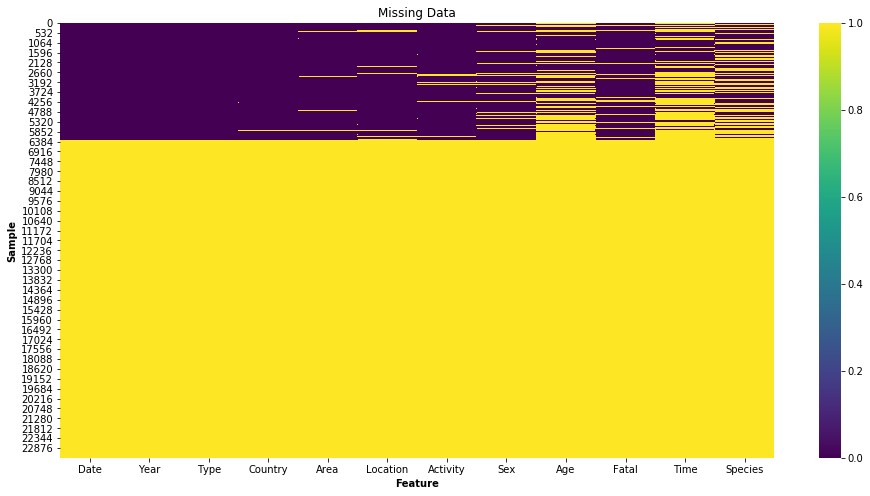

In [40]:
def missing_data_heatmap(df):
    """Plots a heatmap of missing data in the DataFrame.
    
    Arguments:
    df -- the DataFrame
    """
    # Use heatmap to visualise missing data.
    missing = df.isnull()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(missing, cmap='viridis', ax=ax)
    plt.title('Missing Data')
    plt.xlabel('Feature', fontweight='bold')
    plt.ylabel('Sample', fontweight='bold')
    plt.show()
    
missing_data_heatmap(df)

### Drop Rows with All NaN

Now that we know we have many rows of missing data, we can drop all empty samples.

In [41]:
# Remove empty rows.
df = df.dropna(how='all')

### Drop Columns with > 50% Missing Data

In this investigation, we've chosen a threshold of 50% for missing data in a column. If a column contains more missing data than the threshold, let's remove it from the analysis.

In [42]:
# Show percentage of missing values per column.
col_miss_perc = 100 * df.isnull().sum() / len(df)
col_miss_perc

Date         0.000000
Year         0.031511
Type         0.063022
Country      0.787774
Area         7.200252
Location     8.523712
Activity     8.618245
Sex          8.901843
Age         44.855837
Fatal        8.539467
Time        53.032929
Species     45.123680
dtype: float64

In [43]:
# Drop columns with more than 50% data missing.
cols = col_miss_perc[col_miss_perc > 50].index
df = df.drop(cols, axis=1)

In [44]:
# View sample of remaining columns.
df.head(n=10)

,Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Fatal,Species
0,8-Jan-2019,2019.0,Unprovoked,USA,California,"Sandspit Beach, Montaña de Oro State Park",Surfing,M,19,N,"White shark, 4.6m"
1,18-Dec-2018,2018.0,Unprovoked,MEXICO,Sonora,Southeast of Puerto Peñasco,Diving,M,35,Y,Tiger shark
2,15-Dec-2018,2018.0,Provoked,AUSTRALIA,New South Wales,NaN,NaN,M,48,N,Wobbegong shark
3,15-Dec-2018,2018.0,Provoked,NEW ZEALAND,North Island,Matauri Bay,Spearfishing,M,24,N,"Mako shark, 7'"
4,09-Dec-2018,2018.0,Unprovoked,NEW ZEALAND,North Island,Ti Point,Spearfishing,M,50,N,Bronze whaler 2.5m
5,09-Dec-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Nambucca,Surfing,M,36,N,NaN
6,18-Nov-2018,2018.0,Unprovoked,AUSTRALIA,Northern Territory,Off Nhulunbuy,Spearfishing,M,17,N,Reef shark x 2
7,17-Nov-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,"7 Mile Beach, Gerroa",Surfing,M,24,N,NaN
8,11-Nov-2018,2018.0,Unprovoked,SOUTH AFRICA,KwaZulu-Natal,Tinley Manor,Fishing,M,41,N,"White shark, 3m"
9,11-Nov-2018,2018.0,Unprovoked,AUSTRALIA,Western Australia,"Pyramids Beach, Mandurah",Body Boarding,M,20,N,Sandtiger shark


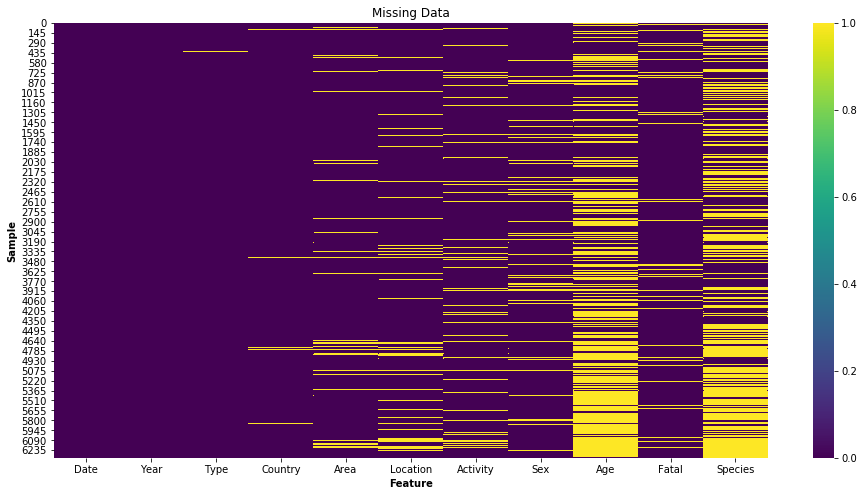

In [45]:
# Visualise missing data.
missing_data_heatmap(df)

## Clean Data

### Relabel Incorrect Data

There are many labels that should be labelled the same but have some minor mistake in spelling or case. Eg. 'Boating' and 'Boat' in the 'Activity' column.

In [46]:
def relabel_matching(df, col, search_term, new_label, case=False, without=[], log=False):
    """Relabels labels matching a search string to a new label.
    
    Arguments:
    df -- the Dataframe
    col -- the column in which the label exists
    search_term -- the string or regex to search for in current labels
    new_label -- replace matching labels with this label
    case -- is the string matching case sensitive? (default False)
    without -- don't relabel strings that include any of these matches. This logic could be included in regex,
        but this makes it simpler for those who aren't regex power users and aren't comfortable with negative
        lookahead and lookbehinds (default [])
    log -- log the labels that were relabelled (default False)
    """
    # Clone the DF.
    df = df.copy()
    
    # Get the series.
    series = df[col]
    
    # Get the affected rows.
    rows = series.str.contains(search_term, case=case)
    rows = rows.fillna(False)  # Replace any NaN values with False.
    
    # Remove any rows that match 'without'.
    for w in without:
        matches = series.str.contains(w, case=case)
        matches = matches.fillna(False)
        rows[matches] = False
        
    # Log the changes.
    if log:
        relabelled = df.loc[rows, col].unique()
        print(f"Relabelled: {relabelled}")
    
    # Replace the labels for each affected row.
    df.loc[rows, col] = new_label
    
    return df

Show the example 'Type' column, where we'll combine the 'Boating' and 'Boat' labels.

In [47]:
# Get value counts for Type.
df['Type'].value_counts()

Unprovoked             4627
Provoked                581
Invalid                 550
Sea Disaster            239
Boating                 203
Boat                    137
Questionable              4
Boatomg                   1
Under investigation       1
Name: Type, dtype: int64

In [48]:
# Boating, Boat and Boatomg are probably all 'Boating', combine these labels.
df = relabel_matching(df, 'Type', 'Boat', 'Boating')
df['Type'].value_counts()

Unprovoked             4627
Provoked                581
Invalid                 550
Boating                 341
Sea Disaster            239
Questionable              4
Under investigation       1
Name: Type, dtype: int64

In [49]:
# Relabel mislabelled countries.
df = df.replace({'Country': {'Fiji': 'FIJI', 'Seychelles': 'SEYCHELLES', 'Sierra Leone': 'SIERRA LEONE',
                                        'Coast of AFRICA': 'AFRICA'}})

In [50]:
# Relabel mislabelled activities.
df = df.replace({'Activity': {'Boogie boarding': 'Body surfing', 'Scuba Diving': 'Scuba diving',
                                        'Freediving': 'Free diving', 'Boogie Boarding': 'Body surfing',
                                        'Surf-skiing': 'Surf skiing',
                                        'Surfing (sitting on his board)': 'Sitting on surfboard',
                                        'Fishing for sharks': 'Shark fishing', 'Kayaking / Fishing': 'Kayak Fishing'}})

In [51]:
# Build list of relabels.
species = [
    { 'from': 'white shark', 'to': 'White shark' },
    { 'from': 'bull shark', 'to': 'Bull shark' },
    { 'from': 'wobbegong shark', 'to': 'Wobbegong shark' },
    { 'from': 'tiger shark', 'to': 'Tiger shark', 'without': ['sand'] },  # Don't relabel 'Sand tiger shark', different species.
    { 'from': 'mako shark', 'to': 'Mako shark' },
    { 'from': 'blue shark', 'to': 'Blue shark' },
    { 'from': 'raggedtooth shark', 'to': 'Raggedtooth shark' },
    { 'from': 'zambesi shark', 'to': 'Bull shark' },  # 'Bull shark' goes by the name 'Zambesi shark' in Africa.
    { 'from': 'hammerhead shark', 'to': 'Hammerhead shark' },
    { 'from': 'basking shark', 'to': 'Basking shark' },
    { 'from': 'oceanic whitetip shark', 'to': 'Oceanic whitetip shark' },
    { 'from': 'grey reef shark', 'to': 'Grey reef shark' },
    { 'from': 'angel shark', 'to': 'Angel shark' },
    { 'from': 'caribbean reef shark', 'to': 'Caribbean reef shark' },
    { 'from': 'galapagos shark', 'to': 'Galapagos shark' },
    { 'from': 'sevengill shark', 'to': 'Sevengill shark' },
    { 'from': 'grey nurse shark', 'to': 'Sand tiger shark' },
    { 'from': 'sandtiger shark', 'to': 'Sand tiger shark' },
    { 'from': 'lemon shark', 'to': 'Lemon shark' },
    { 'from': 'bronze whaler', 'to': 'Bronze whaler shark' },
    { 'from': 'blacktip shark', 'to': 'Blacktip reef shark' },
    { 'from': r'Blacktip (")?reef(")? shark', 'to': 'Blacktip reef shark' },
    { 'from': 'nurse shark', 'to': 'Nurse shark', 'without': ['grey'] },  # Don't want to include the 'Grey nurse shark', separate species.
    { 'from': 'tiger shark', 'to': 'Tiger shark', 'without': ['sand'] },  # Don't want to include the 'Sand tiger shark', separate species.
    { 'from': 'spinner shark', 'to': 'Sevengill shark', 'without': ['blacktip'] },  # Don't want to include 'Blacktip or spinner shark' statements.
]

for s in species:
    without = s['without'] if 'without' in s else []
    df = relabel_matching(df, 'Species', s['from'], s['to'], without=without, log=True)

Relabelled: ['White shark, 4.6m' 'White shark, 3m' 'White Shark, 3.2m to 3.5m'
 'White shark, 5m female' 'White shark' 'White shark, 3.5 m'
 'White shark, 2.5 m' 'Juvenile white shark, 2.7 to 3.2 m'
 'White shark, 4.6 m' 'White shark, 4.5 m' 'White shark, 3.5m'
 'White shark, 3 to 3.5m' 'White shark, 3 m' "White shark, 5' to 7'"
 "White shark, 10'" "White shark, 11' to 13'" "White shark, 8' to 10'"
 "White shark, 9'" 'White shark, 4 m' "White shark, female, 14'"
 "White shark, 10' to 12'" "White shark, 19'" "White shark, 11' to 12'"
 "White shark, 13'" 'White shark, 3.9 to 4.2 m' "White shark, 7'"
 'White shark, 2m to 3 m' 'White shark, 6 m'
 'White shark or oceanic whitetip shark' 'White shark, 4 to 5 m'
 "White shark, 18' to 20'" '2 white shark: 13\' & 9"8"'
 "White shark, 12' to 14'" "white shark, 15'" '3 m to 4 m white shark'
 'Thought to involve a white shark' "White shark, 10 '"
 'Reported to involve a white shark'
 'Reported to involve a 4 m white shark' 'White shark, 4m'
 'Whit

/Users/breclark/anaconda3/envs/investigations/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


### Convert to Numeric

Convert the 'Age' column to numeric. Any values that can't be converted to a numeric (e.g. 'Teen'), will be converted to 'NaN'.

In [52]:
# Convert 'Age' to numeric column. Replaces non-numeric values with 'NaN'.
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

### Convert to DateTime

Convert the Date column to a DateTime column.

In [63]:
# Convert to DateTime format.
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y', errors='coerce')

## Q1: Are shark attacks fatal?

In [64]:
# Get the count of fatal attacks.
fatal = df['Fatal']
value_counts = fatal.value_counts()

print(value_counts)

N          4340
Y          1391
UNKNOWN      71
M             1
y             1
2017          1
Name: Fatal, dtype: int64


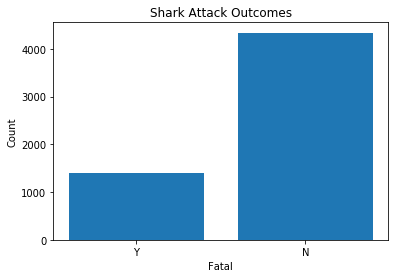

In [65]:
# Plot the results for those outcomes we're interested in.
outcomes = ['Y', 'N']
values = list(map(lambda v: value_counts[v], outcomes))
plt.bar(outcomes, values)
plt.title('Shark Attack Outcomes')
plt.xlabel('Fatal')
plt.ylabel('Count')
plt.show()

In [66]:
# What percentage of shark attacks are fatal?
perc = 100 * value_counts['Y'] / (value_counts['Y'] + value_counts['N'])
print(f"{perc:.2f}% of shark attacks are fatal.")

24.27% of shark attacks are fatal.


From the data we can see that only a quarter of shark attacks end in a fatality.

### How does this percentage change when we split the data?

Let's split the data by column values and see what percentage of the resulting samples fall into either the 'Y' or 'N' columns.

In [67]:
def plot_percentages(df, col, included_values, vertical_labels=True):
    """Plots the percentages of Fatal shark attacks for each unique value in the specified column.
    
    Arguments:
    df -- the DataFrame
    col -- the column to pull values from
    included_values -- the values to pull from the column. In many cases there may be too many unique
        values so let's specify a subset
    vertical_labels -- display x-label values vertically (default True)
    
    """
    # Get value counts.
    value_counts = df[col].value_counts()

    # Keep those values we're interested in.
    slim_value_counts = {}
    for val in included_values:
        slim_value_counts[val] = value_counts[val]

    # Get percentage for each value.
    percs = []
    for value, count in slim_value_counts.items():
        # Get the rows where the col has the value of interest.
        sub_df = df[df[col] == value]

        # Get value counts for subset.
        sub_v_counts = sub_df['Fatal'].value_counts()
        
        # Get Y/N counts.
        y_count = sub_v_counts['Y'] if 'Y' in sub_v_counts else 0
        n_count = sub_v_counts['N'] if 'N' in sub_v_counts else 0

        # Calculate percentage of fatalities.
        perc = 100 * y_count / (y_count + n_count)
        percs.append(perc)

    # Plot the results.
    x = np.arange(len(percs))
    plt.bar(x, percs, width=0.5)
    plt.title(f"Percentage of Fatal Shark Attacks by {col}")
    if vertical_labels:
        plt.xticks(rotation='vertical')
    plt.xticks([x for x in range(len(included_values))], included_values)
    plt.xlabel(col, fontweight='bold')
    plt.ylabel("Percentage of Fatal Attacks", fontweight='bold')
    plt.show()

### Split by Species

It seems that the Tiger shark has the highest percentage of fatal attacks compared to any other species, although it is quite close between this, the White shark and the Bull shark. Interestingly, there are a number of other species that aren't recorded as being responsible for any fatal attacks. We can see that the Wobbegong shark and Blacktip reef shark among others, while attacking humans, generally don't cause enough injury for the attack to be fatal.

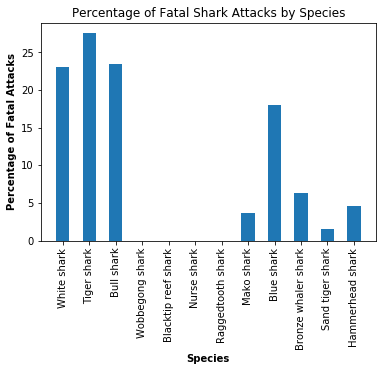

In [364]:
plot_percentages(df, 'Species', ['White shark', 'Tiger shark', 'Bull shark', 'Wobbegong shark', 
                                        'Blacktip reef shark', 'Nurse shark', 'Raggedtooth shark', 'Mako shark', 
                                        'Blue shark', 'Bronze whaler shark', 'Sand tiger shark',
                                        'Hammerhead shark'])

### Split by Sex

Sex here denotes the gender of the victim of the attack. It seems that males are more likely to be involved in a fatal attack with a shark, by a margin of around 7%.

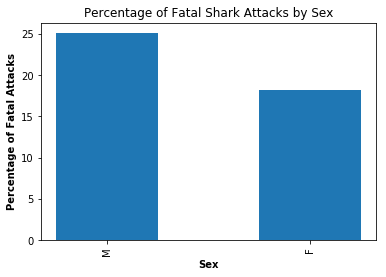

In [365]:
plot_percentages(df, 'Sex', ['M', 'F'])

### Split by Activity

From these results it is clear that the activity you're undertaking has a large effect on whether the attack is likely to be fatal. For example, the likelihood of the attack being fatal drops to 5% if you're surfing. If you're swimming, or bathing, the likelihood of fatality is 40% and 47% respectively. When surfing, there is likely additional protection such as a wetsuit and board, which may prevent some of the severity of the attack. Additionally, the surfboard may provide a means of escape. The attack is most likely to be fatal if you've fallen overboard (90%). The victim is likely in a vulnerable position when having fallen overboard, and may not be able to escape or fight back as effectively.

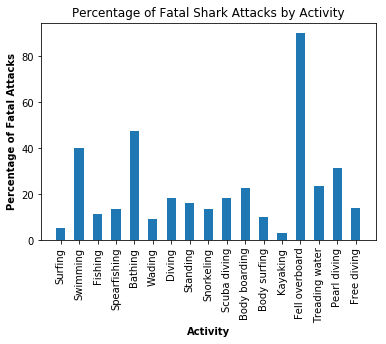

In [366]:
plot_percentages(df, 'Activity', ['Surfing', 'Swimming', 'Fishing', 'Spearfishing', 'Bathing', 'Wading', 'Diving', 
                              'Standing', 'Snorkeling', 'Scuba diving', 'Body boarding', 'Body surfing', 'Kayaking', 
                              'Fell overboard', 'Treading water', 'Pearl diving', 'Free diving'])

### Split by Country

There is large variation in the rate of fatality when split by country. The USA and Bahamas tend to have a relatively low rate of fatality, around 9%, compared to Mexico and Papua New Guinea, with 55% and 43%. Perhaps this is due to the active species in the area, or the availability of emergency services to respond to the incident.

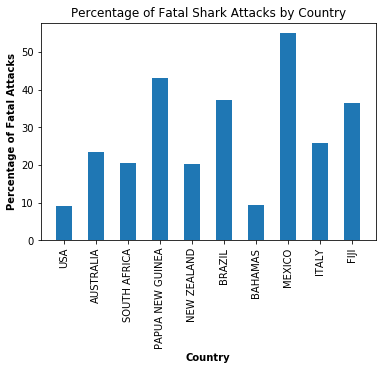

In [367]:
plot_percentages(df, 'Country', ['USA', 'AUSTRALIA', 'SOUTH AFRICA', 'PAPUA NEW GUINEA', 'NEW ZEALAND',
                                       'BRAZIL', 'BAHAMAS', 'MEXICO', 'ITALY', 'FIJI'])

## Q2: Can we predict fatality?

In [368]:
# Visualise our data.
df.head()

,Year,Type,Country,Area,Location,Activity,Sex,Age,Fatal,Species
0,2019.0,Unprovoked,USA,California,"Sandspit Beach, Montaña de Oro State Park",Surfing,M,19.0,N,White shark
1,2018.0,Unprovoked,MEXICO,Sonora,Southeast of Puerto Peñasco,Diving,M,35.0,Y,Tiger shark
2,2018.0,Provoked,AUSTRALIA,New South Wales,NaN,NaN,M,48.0,N,Wobbegong shark
3,2018.0,Provoked,NEW ZEALAND,North Island,Matauri Bay,Spearfishing,M,24.0,N,Mako shark
4,2018.0,Unprovoked,NEW ZEALAND,North Island,Ti Point,Spearfishing,M,50.0,N,Bronze whaler shark


### Remove Incorrect Targets

We're only interested in Y/N outcomes, let's remove all other samples.

In [369]:
# Remove incorrect 'Fatal' values.
df = df[df['Fatal'].isin(['Y', 'N'])]

### Impute Missing Numerical Values

We're going to fill missing values in the numerical columns with the column mean.

In [370]:
# Get columns with numberic data types.
df.dtypes[df.dtypes == 'float64']

Year    float64
Age     float64
dtype: object

In [371]:
# Percentage of missing data.
perc = 100 * df['Year'].isnull().sum() / len(df)
print(f"Year: {perc:.2f}%")

perc = 100 * df['Age'].isnull().sum() / len(df)
print(f"Age: {perc:.2f}%")

Year: 0.02%
Age: 44.65%


In [372]:
# Impute the missing values.
df = df.fillna(df.mean())
df.head(n=15)

,Year,Type,Country,Area,Location,Activity,Sex,Age,Fatal,Species
0,2019.0,Unprovoked,USA,California,"Sandspit Beach, Montaña de Oro State Park",Surfing,M,19.000000,N,White shark
1,2018.0,Unprovoked,MEXICO,Sonora,Southeast of Puerto Peñasco,Diving,M,35.000000,Y,Tiger shark
2,2018.0,Provoked,AUSTRALIA,New South Wales,NaN,NaN,M,48.000000,N,Wobbegong shark
3,2018.0,Provoked,NEW ZEALAND,North Island,Matauri Bay,Spearfishing,M,24.000000,N,Mako shark
4,2018.0,Unprovoked,NEW ZEALAND,North Island,Ti Point,Spearfishing,M,50.000000,N,Bronze whaler shark
5,2018.0,Unprovoked,AUSTRALIA,New South Wales,Nambucca,Surfing,M,36.000000,N,NaN
6,2018.0,Unprovoked,AUSTRALIA,Northern Territory,Off Nhulunbuy,Spearfishing,M,17.000000,N,Reef shark x 2
7,2018.0,Unprovoked,AUSTRALIA,New South Wales,"7 Mile Beach, Gerroa",Surfing,M,24.000000,N,NaN
8,2018.0,Unprovoked,SOUTH AFRICA,KwaZulu-Natal,Tinley Manor,Fishing,M,41.000000,N,White shark
9,2018.0,Unprovoked,AUSTRALIA,Western Australia,"Pyramids Beach, Mandurah",Body Boarding,M,20.000000,N,Sand tiger shark


### Matrix of Features

Which features can we use as predictors? This data will be used for training and testing our models.

In [373]:
# Create feature matrix.
X = df.loc[:, df.columns != 'Fatal']
X.head()

,Year,Type,Country,Area,Location,Activity,Sex,Age,Species
0,2019.0,Unprovoked,USA,California,"Sandspit Beach, Montaña de Oro State Park",Surfing,M,19.0,White shark
1,2018.0,Unprovoked,MEXICO,Sonora,Southeast of Puerto Peñasco,Diving,M,35.0,Tiger shark
2,2018.0,Provoked,AUSTRALIA,New South Wales,NaN,NaN,M,48.0,Wobbegong shark
3,2018.0,Provoked,NEW ZEALAND,North Island,Matauri Bay,Spearfishing,M,24.0,Mako shark
4,2018.0,Unprovoked,NEW ZEALAND,North Island,Ti Point,Spearfishing,M,50.0,Bronze whaler shark


### Target Vector

The values we're trying to predict.

In [374]:
# Create vector of targets.
y = df['Fatal']
y.head()

0    N
1    Y
2    N
3    N
4    N
Name: Fatal, dtype: object

### Label Encoding

Performing label encoding on the target vector transforms from Y/N values to 1/0 values.

In [375]:
# Perform label encoding on target vector.
le = LabelEncoder()
y = pd.Series(le.fit_transform(df['Fatal']))
y.head()

0    0
1    1
2    0
3    0
4    0
dtype: int64

### One-hot encoding

Encode our categorical variables so that each category has its own column.

In [376]:
# Create dummy variables.
X = pd.get_dummies(X)
X.head()

,Year,Age,Type_Boating,Type_Invalid,Type_Provoked,Type_Questionable,Type_Sea Disaster,Type_Under investigation,Type_Unprovoked,Country_ADMIRALTY ISLANDS,...,"Species_reef shark, 1m",Species_reef shark?,Species_sand shark,Species_small carpet shark,Species_small catsharks,Species_small shark,Species_small sharks,Species_small sharks',Species_whaler shark,Species_“small brown shark”
0,2019.0,19.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2018.0,35.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2018.0,48.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2018.0,24.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2018.0,50.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Training/Testing Set

We're going to create a testing set that contains 30% of our samples. The remaining data will be used for training.

In [377]:
# Split the dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Num training samples: {X_train.shape[0]}")
print(f"Num test samples: {X_test.shape[0]}")

Num training samples: 4011
Num test samples: 1720


### Logistic Regression

Our benchmark model is the logistic regression. By using this model, we're making the assumption that any relationships between the features and the target are linear. This isn't necessarily the case but it provides a good starting point from which we can base the performance of following models.

In [378]:
# Create model.
model = LogisticRegression()

# Fit to the training data.
model.fit(X_train, y_train)

/Users/breclark/anaconda3/envs/investigations/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Model Evaluation

Here we used our trained model to predict the outcomes of the test set samples. Comparing these results to the actual values gives us our model report.

Precision measures the percentage of samples that belonged to a class from all those we assigned to that class.
Precision is calculated as TP / (TP + FP). Recall, however measures the percentage of samples that we assigned to the class from all those that actually belonged in that class. Recall is calculated as TP / (TP + FN).

F1-score indicates the harmonic mean between the precision and the recall. It is calculated as 2 * (Precision * Recall) / (Precision + Recall).

In the report below, 'support' indicates the number of test samples that lie in each of the classes. We can see that of our test samples, the large proportion were for the N case.

Our precision/recall for the N class were quite high (0.86 and 0.91 respectively), our model is quite good at predicting the No case. However, the values for the Y case are much lower (0.61 and 0.47 respectively), so our model isn't as good at predicting the Y case.

In [379]:
# Predict test set outcomes.
y_preds = model.predict(X_test)

In [380]:
# Calculate accuracy score.
accuracy = 100 * accuracy_score(y_test, y_preds)
print(f"Accuracy is {accuracy:.2f}%.")

Accuracy is 81.28%.


In [381]:
# Get classification report.
report = classification_report(y_test, y_preds, target_names=['N', 'Y'])
print(report)

              precision    recall  f1-score   support

           N       0.86      0.91      0.88      1333
           Y       0.61      0.47      0.53       387

   micro avg       0.81      0.81      0.81      1720
   macro avg       0.73      0.69      0.71      1720
weighted avg       0.80      0.81      0.80      1720



### Top Coefficients

We can see which features were seen as the best predictors for the target variable. These are the coefficients with the largest absolute value. A large negative value is an indicator that the feature has a strong negative correlation with the outcome variable.

The top predictors were:
1. Type - Sea Disaster. Strong correlation with fatality.
2. Activity - Surfing. Strong correlation with survival.
3. Type - Boating. Strong correlation with survival.
4. Species - Sand tiger shark. Strong correlation with survival.
5. Activity - Fell overboard. Strong correlation with fatality.

In [382]:
def top_coefs(model, n=5):
    """Returns the indexes and values of the columns with the n largest coefficients by absolute value.
    
    Arguments:
    model -- the model. Must respond to the .coef_ method
    n -- the number of coefficients to return (default 5)
    """
    # Get absolute value of all coefficients.
    coefs = model.coef_[0]
    abs_coefs = np.abs(coefs)

    # Gets indexes that would sort the array. '[::-1]' is short-hand for reversing the array.
    idx = np.argsort(abs_coefs)[::-1][0:n]
    vals = [coefs[i] for i in idx]
    
    return [idx, vals]

In [383]:
# Get top 5 coefficients by absolute value.
idx, vals = top_coefs(model, 5)

# Get column names.
cols = X.columns[idx]

# Create dataframe with coefficies.
cfs = pd.DataFrame([vals], columns=cols)

cfs.head()

,Type_Sea Disaster,Activity_Surfing,Type_Boating,Species_Sand tiger shark,Activity_Fell overboard
0,2.180703,-2.013995,-2.00675,-1.920283,1.910798


## Q2: Where do shark attacks occur?

In [384]:
def lat_long(name):
    """Returns the latitude/longitude of the specified location.
    
    Arguments:
    name -- the name of the location
    """
    # Create the client.
    geolocator = Nominatim(user_agent="shark_attacks")
    
    # Fetch location with retries.
    num_retries = 20
    location = None
    for attempt in range(0, num_retries):
        print(f"Fetching '{name}'. Attempt: {attempt}.")
        
        try:
            # Look up location.
            location = geolocator.geocode(name)
        except GeocoderTimedOut:
            print(f"=> Geocoder timed out searching for: '{name}'. Attempt: {attempt}")
            time.sleep(1)
        
        # Break if fetch was successful.
        if location is not None:
            break
        elif attempt == (num_retries - 1):
            # Return bogus values.
            return (np.nan, np.nan)
    
    # Create lat/long tuple.
    lat_long = (location.latitude, location.longitude)
    
    return lat_long

### Build Location Data

We can look up our locations by name using [GeoPy](https://geopy.readthedocs.io/en/stable/). This will provide us with the latitude and longitude of each location for plotting on our world map.

In [385]:
def build_location_data(df):
    """Builds the location data necessary for plotting onto a world map.
    
    Arguments:
    df -- the DataFrame
    """
    # Build dataframe of top 50 locations.
    locs = df['Location'].value_counts()[0:50]

    # Combine 'Near Thursday Island' with 'Thursday Island'.
    locs = locs.reset_index().replace({'index': {'Near Thursday Island': 'Thursday Island'}}).groupby('index', sort=False).sum()['Location']

    # Rename a few locations. Geopy API was having trouble finding these places.
    renames = [
        ['Ponce Inlet, New Smyrna Beach, Volusia County', 'Ponce Inlet, Volusia County'],
        ['Ahvaz, on the Karun River', 'Ahvaz'],
        ['Sydney Harbor', 'Sydney Harbour, Australia'],
        ['Sydney', 'Sydney Harbour, Australia'],
        ['Ellis Beach, 20 miles from Cairns', 'Ellis Beach, Cairns'],
        ['Back Beach, Durban', 'Durban Beach']
    ]
    
    # Do renaming.
    for frm, to in renames:
        locs = locs.rename(index={frm: to})
    locs = locs.reset_index().groupby('index', sort=False).sum()['Location']
    
    # Remove some locations, we can't find these through Geopy.
    removes = [
        'Off Lodestone Reef, Great Barrier Reef, north of Townsville'
    ]
    
    # Do removing.
    for name in removes:
        if name in locs.index:
            locs = locs.drop(index=name)

    # Take first part of location name.
    strip = lambda s: s.split(',')[0]
    loc_names = list(map(strip, locs.index.values))

    # Create initial features.
    location_data = pd.DataFrame({
        'Location': loc_names,
        'Shark Attacks': locs.values
    })
    
    # Add latitude/longitude. This could take a little while, API calls are being made.
    lat_longs = list(map(lat_long, locs.index.values))
    location_data['Latitude'] = pd.Series(list(map(lambda l: l[0], lat_longs)))
    location_data['Longitude'] = pd.Series(list(map(lambda l: l[1], lat_longs)))
    
    return location_data

In [386]:
# Build data for world map plot.
location_data = build_location_data(df)

Fetching 'New Smyrna Beach, Volusia County'. Attempt: 0.
Fetching 'Daytona Beach, Volusia County'. Attempt: 0.
Fetching 'Cocoa Beach, Brevard County'. Attempt: 0.
Fetching 'Ponce Inlet, Volusia County'. Attempt: 0.
=> Geocoder timed out searching for: 'Ponce Inlet, Volusia County'. Attempt: 0
Fetching 'Ponce Inlet, Volusia County'. Attempt: 1.
=> Geocoder timed out searching for: 'Ponce Inlet, Volusia County'. Attempt: 1
Fetching 'Ponce Inlet, Volusia County'. Attempt: 2.
Fetching 'Melbourne Beach, Brevard County'. Attempt: 0.
=> Geocoder timed out searching for: 'Melbourne Beach, Brevard County'. Attempt: 0
Fetching 'Melbourne Beach, Brevard County'. Attempt: 1.
Fetching 'Myrtle Beach, Horry County'. Attempt: 0.
Fetching 'Isle of Palms, Charleston County'. Attempt: 0.
=> Geocoder timed out searching for: 'Isle of Palms, Charleston County'. Attempt: 0
Fetching 'Isle of Palms, Charleston County'. Attempt: 1.
=> Geocoder timed out searching for: 'Isle of Palms, Charleston County'. Attemp

In [387]:
# Show the data.
location_data.head()

,Location,Shark Attacks,Latitude,Longitude
0,New Smyrna Beach,168,29.025819,-80.926998
1,Daytona Beach,34,29.210815,-81.022833
2,Cocoa Beach,24,28.329849,-80.620547
3,Ponce Inlet,34,29.096373,-80.936998
4,Melbourne Beach,18,28.068350,-80.560330


### Creating World Map with Attack Distribution 

We create the world map using the [Folium](https://python-visualization.github.io/folium) library.

In [388]:
def plot_world_map(data, temp_file='map.html'):
    """Displays a world map with the location data.
    
    Arguments:
    data -- a DataFrame containing Location, Latitude, Longitude and Shark Attacks columns.
    """
    # Create the empty map, centered on largest point.
    p = data.iloc[data['Shark Attacks'].idxmax()]
    m = folium.Map(location=[0, 20], tiles='Mapbox Bright', zoom_start=2)

    # Add points to the map. i=index, p=point.
    for i, p in data.iterrows():
        # Create hover-over text.
        tooltip = f"{p['Location']}: {p['Shark Attacks']}"

        # Create radius of marker.
        radius = p['Shark Attacks'] * 0.5

        # Create the marker.
        marker = folium.CircleMarker(
            location=[p['Latitude'], p['Longitude']],
            radius=radius,
            tooltip=tooltip,
            color='crimson',
            fill=True,
            fill_color='crimson'
        )

        # Add point to map.
        marker.add_to(m)

    # Save HTML map to temp file.
    m.save(temp_file)
    
    # Load the HTML in an iframe.
    iframe = IFrame(src=temp_file, width=1000, height=500)
    
    return iframe

We can see a concentration of attacks on the lower east coast of the USA, along the coast of Africa and at certain sites in Australia.

In [389]:
# Create world map of shark attacks.
plot_world_map(location_data)

### Fatal Attack Distribution

In [390]:
# Get samples with fatal outcome.
fatal_df = df[df['Fatal'] == 'Y']

In [391]:
# Build data for world map plot.
fatal_location_data = build_location_data(fatal_df)

Fetching 'Ahvaz'. Attempt: 0.
Fetching 'Boa Viagem, Recife'. Attempt: 0.
Fetching 'Xai Xai'. Attempt: 0.
=> Geocoder timed out searching for: 'Xai Xai'. Attempt: 0
Fetching 'Xai Xai'. Attempt: 1.
Fetching 'Durban'. Attempt: 0.
Fetching 'Ross River, Townsville'. Attempt: 0.
Fetching 'Havana Harbor'. Attempt: 0.
Fetching 'Boa Viagem Beach, Recife'. Attempt: 0.
Fetching 'North Beach, Durban'. Attempt: 0.
Fetching 'Noumea'. Attempt: 0.
Fetching 'Piedade'. Attempt: 0.
Fetching 'Pensacola Bay, Escambia County'. Attempt: 0.
Fetching 'Second Beach, Port St. John's'. Attempt: 0.
Fetching 'Coco Beach, Dar-es-Salaam'. Attempt: 0.
Fetching 'Charleston Harbor, Charleston County'. Attempt: 0.
Fetching 'Piedade, Recife'. Attempt: 0.
Fetching 'Mogadishu'. Attempt: 0.
Fetching 'Grenville'. Attempt: 0.
Fetching 'Stockton Beach, Newcastle'. Attempt: 0.
Fetching 'Badu Island'. Attempt: 0.
Fetching 'Revolcadero Beach, Acapulco'. Attempt: 0.
Fetching 'Mobile Bay'. Attempt: 0.
Fetching 'Fort Mills'. Attempt:

In [392]:
# Plot the world map.
fatal_location_data.head()

,Location,Shark Attacks,Latitude,Longitude
0,Ahvaz,7,31.322102,48.680574
1,Boa Viagem,6,-8.123503,-34.903396
2,Xai Xai,6,-25.044479,33.640730
3,Durban,5,-29.861825,31.009909
4,Ross River,5,-19.480002,146.793060


In [393]:
# Create world map of fatal shark attacks.
plot_world_map(fatal_location_data)

#### Species and Location

By looking at the crosstabulation of Species and Location, we can see immediately any clustering of shark attacks. For example, it seems that the Blacktip reef shark is very active at New Smyrna Beach and Myrtle Beach, while the Nurse shark is active in the Florida region.

In [394]:
def plot_crosstab(df, col_x, col_y, num_x=20, num_y=20):
    """Plots the crosstabulation (joint freqency distribution) of the columns A and B as a heatmap.
    
    Arguments:
    df -- the DataFrame
    col_a -- the first column
    col_b -- the second column
    title -- the title of the plot (default '')
    xlabel -- the x-label of the plot (default '')
    ylabel -- the y-label of the plot (default '')
    """
    # Subset data by 20 most frequent values in column x.
    a_vals = df[col_x].value_counts().iloc[0:num_x].index.values
    df_x = df[df[col_x].isin(a_vals)]
    
    # Subset data by 20 most frequest values in column y.
    b_vals = df_x[col_y].value_counts().iloc[0:num_y].index.values
    df_y = df_x[df_x[col_y].isin(b_vals)]
    
    # Get the crosstabulation.
    crosstab = pd.crosstab(df_y[col_y], df_y[col_x])
    
    # Create the title.
    title = f"Crosstabulation of {col_x} and {col_y}"
    
    # Plot the crosstabulation.
    fig, ax = plt.subplots(figsize=(12,6))
    sns.heatmap(crosstab, ax=ax)
    plt.title(title)
    plt.xlabel(col_x, fontweight='bold')
    plt.ylabel(col_y, fontweight='bold')
    plt.show()

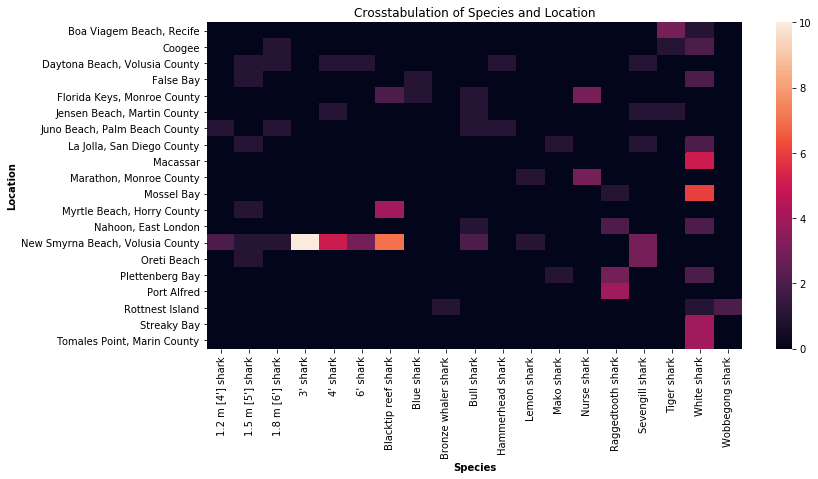

In [395]:
# Plot the frequency distribution.
plot_crosstab(df, 'Species', 'Location')